## neural network

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as sio
import scipy.optimize as opt
from sklearn.metrics import classification_report

In [4]:
def load_data(path, transpose=True):
    # 加载数据
    
    # 加载mat格式的文件 type(data): dict
    data = sio.loadmat(path)
    X = data.get('X')
    y = data.get('y')
    y = y.reshape(y.shape[0])  # 这里把y的rank变成1,到时候用的时候既可以表示行向量也可以表示列向量。这里是表示列向量
    
    # 迷惑，以下步骤没有作用
#     if transpose:
#         # for this dataset, you need a transpose to get the orientation right
#         X = np.array([im.reshape((20, 20)).T for im in X])

#         # and I flat the image again to preserve the vector presentation
#         X = np.array([im.reshape(400) for im in X])

    return X, y
        
    

In [5]:
X, y = load_data('ex3data1.mat')

In [6]:
X.shape, y.shape

((5000, 400), (5000,))

### matplotlib.pyplot.matshow()画图
https://blog.csdn.net/qq_26822029/article/details/91351231

In [7]:
def plot_an_image(image):
    # 绘图
    _, ax = plt.subplots(figsize=(1, 1))
    ax.matshow(image.reshape(20, 20), cmap=matplotlib.cm.binary)
    # 取消x轴上的刻度线 
    plt.xticks([])
    plt.yticks([])
    plt.show()

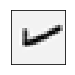

really number:7


In [8]:
pick_one = np.random.randint(0, 5000)
plot_an_image(X[pick_one, :])
print('really number:%d' % y[pick_one])

In [9]:
def plot_100_image(X):
    """ sample 100 image and show them
    assume the image is square

    X : (5000, 400)
    """
    # 获取图像大小的设置
    size = int(np.sqrt(X.shape[1]))
    
    # 随机选择X中的100行数据
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)
    sample_images = X[sample_idx, :]
    
    # 定义子plot
    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharex=True, sharey=True, figsize=(8, 8))
    for i in range(10):
        for j in range(10):
            # 矩阵可视化
            ax_array[i, j].matshow(sample_images[i*10+j, :].reshape(20,20), cmap=matplotlib.cm.binary)
            
            plt.xticks([])
            plt.yticks([])
    

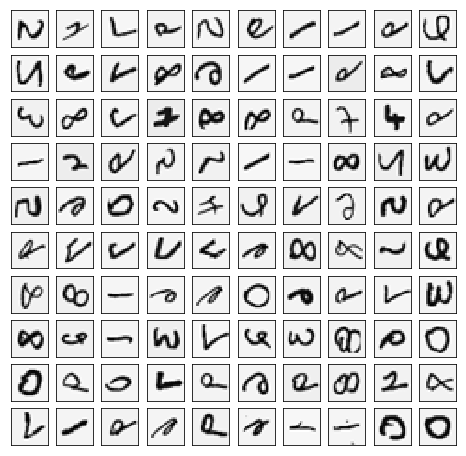

In [10]:
plot_100_image(X)
plt.show()

In [11]:
raw_X, raw_y = load_data('ex3data1.mat')
raw_X.shape, raw_y.shape

((5000, 400), (5000,))

In [12]:
raw_X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
raw_y

array([10, 10, 10, ...,  9,  9,  9], dtype=uint8)

## 准备数据

In [14]:
# add intercept=1 for x0
X = np.insert(raw_X, 0, values=np.ones(raw_X.shape[0]), axis=1)#插入了第一列（全部为1）
X.shape

(5000, 401)

In [15]:
set(raw_y)


{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [16]:
# 处理y的值，因为y的类别有10个，所以需要将 5000*1 映射为  5000*10
y_matrix = []
for i in range(1, 11):
    # 将True/False的掩码转换为1/0m，方便后面计算
    y_matrix.append((raw_y == i).astype(int))

# 因为最开始的10在最前面，这里需要处理下
y_matrix = [y_matrix[-1]] + y_matrix[:-1]

y = np.array(y_matrix)


In [17]:
y.shape

(10, 5000)

## 训练一维模型

In [18]:
def sigmoid(z):
    # 定义sigmoid函数
    return 1 / (1 + np.exp(-z))

In [19]:
def gradient(theta, X, y, learning_rate=1):
    # 定义逻辑回归函数的梯度下降函数
    return (learning_rate/len(X)) * X.T @ (sigmoid(X @ theta) - y)

In [20]:
def cost(theta, X, y):
    # 定义逻辑回归函数的代价函数
    first = -y * np.log(sigmoid(X @ theta))
    second = -(1-y) * np.log(1 - sigmoid(X @ theta))
    return np.mean(first + second)

In [21]:
def regularized_cost(theta, X, y, learning_rate=1):
    # 定义加入正则化的逻辑回归函数的代价函数
    theta_1_to_n = theta[1:]  # theta[0]不参与正则化
    term = (learning_rate/(2 * len(X))) * np.power(theta_1_to_n, 2).sum()
    
    return cost(theta, X, y) + term

In [22]:
def regularized_gradient(theta, X, y, learning_rate=1):
    # 定义加入正则化的逻辑回归的梯度下降函数
    theta_1_to_n = theta[1:]  # theta[0]不参与正则化
    
    regularized_theta = (learning_rate/len(X)) * theta_1_to_n
    
    regularized_term = np.concatenate([np.array([0]), regularized_theta])
    return gradient(theta, X, y) + regularized_term

In [23]:
def logistic_regression(X, y, learning_rate=1):
    """generalized logistic regression(广义逻辑回归)
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, )
        l: lambda constant for regularization

    return: trained parameters
    """
    # 初始化theta
    theta = np.zeros(X.shape[1])
    
    res = opt.minimize(fun=regularized_cost, x0=theta, 
                       args=(X, y, learning_rate), 
                       jac=regularized_gradient, 
                       method='TNC', 
                       options={'disp': True})
    
    return res.x

In [24]:
def predict(x, theta):
    # 预测函数
    prob = sigmoid(x @ theta)
    return (prob >= 0.5).astype(int)

In [25]:
X.shape, y.shape

((5000, 401), (10, 5000))

In [26]:
t0 = logistic_regression(X, y[0])

In [27]:
t0, t0.shape

(array([-5.40016049e+00,  0.00000000e+00,  0.00000000e+00, -2.22683861e-09,
        -6.70121002e-06,  7.49081268e-05,  7.09084247e-04,  2.25842412e-04,
         6.05653630e-05, -1.43127453e-04, -1.06509589e-03, -2.23328113e-04,
         2.69567610e-04,  4.63375071e-04,  2.72253958e-03,  2.36978841e-03,
         1.34604590e-05,  8.52959978e-06,  3.21281912e-07, -2.06131642e-07,
         0.00000000e+00, -1.62352647e-09, -8.75267788e-06, -1.46262963e-05,
         1.09760740e-03,  1.99405293e-03, -5.50796375e-03,  2.30677170e-03,
         4.91341515e-03,  2.86903248e-03,  1.20426249e-02,  8.35600889e-03,
         5.87536705e-03,  2.08930788e-03, -2.01098422e-02, -2.39965094e-02,
        -2.70546519e-03,  3.55788566e-03,  2.89724560e-03, -1.24529442e-04,
         8.30318714e-07,  1.46982244e-08,  5.47427170e-05, -4.73657213e-05,
        -4.88631819e-03, -1.90430147e-02, -3.47532696e-02, -4.90864158e-02,
        -7.93049780e-02, -1.24454752e-01, -1.53619642e-01, -2.24638447e-01,
        -2.7

In [28]:
y_pre = predict(X, t0)
print('accuracy:{}'.format(np.mean(y_pre == y[0])))

accuracy:0.9974


# train k model（训练k维模型）

In [29]:
k_theta = np.array([logistic_regression(X, y[k]) for k in range(10)])  # 这里只是相当于训练了10次？？

In [30]:
k_theta.shape

(10, 401)

# 进行预测
- think about the shape of k_theta, now you are making $X\times\theta^T$
   $(5000, 401) \times (10, 401).T = (5000, 10)$

- after that, you run sigmoid to get probabilities and for each row, you find the highest prob as the answer

In [31]:
prob_matrix = sigmoid(X @ k_theta.T)

In [32]:
prob_matrix.shape

(5000, 10)

In [33]:
# True用固定点打印浮点数符号，当前精度中的数字等于零将打印为零。
# False用科学记数法；最小数绝对值是<1e-4或比率最大绝对值> 1e3。默认值False
np.set_printoptions(suppress=True)
prob_matrix

array([[0.99578169, 0.        , 0.00053514, ..., 0.00006471, 0.00003909,
        0.00172295],
       [0.99834612, 0.0000001 , 0.00005609, ..., 0.00009685, 0.0000029 ,
        0.00008496],
       [0.99139744, 0.        , 0.00056833, ..., 0.00000654, 0.02652894,
        0.00197466],
       ...,
       [0.00000068, 0.04137115, 0.0032124 , ..., 0.00012723, 0.00297373,
        0.70766181],
       [0.00001846, 0.00000013, 0.00000009, ..., 0.00164793, 0.06817902,
        0.86107014],
       [0.02886762, 0.        , 0.00012988, ..., 0.36631529, 0.00497266,
        0.14827277]])

In [34]:
y_pred = np.argmax(prob_matrix, axis=1)  # 回沿轴axis最大值的索引，axis=1代表行
# 这里最大值的索引，对应到y的索引，即为y的实际值

In [35]:
y_pred, y_pred.shape

(array([0, 0, 0, ..., 9, 9, 7]), (5000,))

In [36]:
y_answer = raw_y.copy()
# 这里需要转换成这个样子，是因为最开始的时候，10的值放在最前面
y_answer[y_answer == 10] = 0

In [37]:
print(classification_report(y_answer, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       500
           1       0.95      0.99      0.97       500
           2       0.95      0.92      0.93       500
           3       0.95      0.91      0.93       500
           4       0.95      0.95      0.95       500
           5       0.92      0.92      0.92       500
           6       0.97      0.98      0.97       500
           7       0.95      0.95      0.95       500
           8       0.93      0.92      0.92       500
           9       0.92      0.92      0.92       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



## 神经网络模式

In [38]:
def load_weight(path):
    data = sio.loadmat(path)
    return data['Theta1'], data['Theta2']

In [39]:
theta1, theta2 = load_weight('ex3weights.mat')
theta1.shape, theta2.shape

((25, 401), (10, 26))

因此在数据加载函数中，原始数据做了转置，然而，转置的数据与给定的参数不兼容，因为这些参数是由原始数据训练的。 所以为了应用给定的参数，我需要使用原始数据（不转置）

In [43]:
X, y = load_data('ex3data1.mat')  # 这里有问题？看代码转不转置的结果都是一样的呀
X = np.insert(X, 0, values=np.ones(X.shape[0]), axis=1)
X.shape

(5000, 401)

## feed forward prediction(前馈预测)

In [70]:
a1 = X

In [71]:
z2 = a1 @ theta1.T  # (5000, 401) @ (25, 401).T
z2.shape

(5000, 25)

In [72]:
# 添加第二场神经元的偏置单元
z2 = np.insert(z2, 0, values=np.ones(z2.shape[0]), axis=1)
z2.shape

(5000, 26)

In [73]:
a2 = sigmoid(z2)
a2.shape

(5000, 26)

In [74]:
z3 = a2 @ theta2.T

In [75]:
a3 = sigmoid(z3)
a3

array([[0.00013825, 0.0020554 , 0.00304012, ..., 0.00049102, 0.00774326,
        0.99622946],
       [0.00058776, 0.00285027, 0.00414688, ..., 0.00292311, 0.00235617,
        0.99619667],
       [0.00010868, 0.0038266 , 0.03058551, ..., 0.07514539, 0.0065704 ,
        0.93586278],
       ...,
       [0.06278247, 0.00450406, 0.03545109, ..., 0.0026367 , 0.68944816,
        0.00002744],
       [0.00101909, 0.00073436, 0.00037856, ..., 0.01456166, 0.97598976,
        0.00023337],
       [0.00005908, 0.00054172, 0.0000259 , ..., 0.00700508, 0.73281465,
        0.09166961]])

In [76]:
y_pred = np.argmax(a3, axis=1) + 1   # numpy is 0 base index, +1 for matlab convention，返回沿轴axis最大值的索引，axis=1代表行
y_pred, y_pred.shape

(array([10, 10, 10, ...,  9,  9,  9]), (5000,))

## 准确率
虽然人工神经网络是非常强大的模型，但训练数据的准确性并不能完美预测实际数据，在这里很容易过拟合。

In [77]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.97      0.98      0.97       500
           2       0.98      0.97      0.97       500
           3       0.98      0.96      0.97       500
           4       0.97      0.97      0.97       500
           5       0.98      0.98      0.98       500
           6       0.97      0.99      0.98       500
           7       0.98      0.97      0.97       500
           8       0.98      0.98      0.98       500
           9       0.97      0.96      0.96       500
          10       0.98      0.99      0.99       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

